In [32]:
import numpy as np
import numba
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors
import math
import struct

import xarray

%matplotlib inline
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w",
          "animation.html" : 'html5'}
plt.rcParams.update(params)

In [107]:

def hillshade(data,scale=10.0,azdeg=165.0,altdeg=45.0):
    ''' convert data to hillshade based on matplotlib.colors.LightSource class.
        input: 
             data - a 2-d array of data
             scale - scaling value of the data. higher number = lower gradient 
             azdeg - where the light comes from: 0 south ; 90 east ; 180 north ;
                          270 west
             altdeg - where the light comes from: 0 horison ; 90 zenith
        output: a 2-d array of normalized hilshade 
    '''
    # convert alt, az to radians
    az = azdeg*math.pi/180.0
    alt = altdeg*math.pi/180.0
    # gradient in x and y directions
    dy, dx = np.gradient(data[-1::-1]/float(scale))
    slope = 0.5*math.pi - np.arctan(np.hypot(dx, dy))
    aspect = np.arctan2(dy, dx)
    intensity = np.sin(alt)*np.sin(slope) + np.cos(alt)*np.cos(slope)*np.cos(-az - aspect - 0.5*math.pi)
    return intensity[-1::-1]

In [108]:
def load(var):
    folder = "../build/x64-Release/benchmarks/results/jail/"
    header_size = struct.calcsize("NN")
    with open(folder+var+"-0.bin", "rb") as file:
        header = file.read(header_size)
        result = np.frombuffer(file.read(), dtype = np.float64).astype(np.float64)
    
    nr, nc = struct.unpack("NN", header)
    
    return result.reshape(nr, nc)    

elevation = load('elevation')
simple = load('simple')
sloped = load('sloped')
carved = load('carved')
wsimple = load('wsimple')
wsloped = load('wsloped')
wcarved = load('wcarved')
angles = load('angles')
        

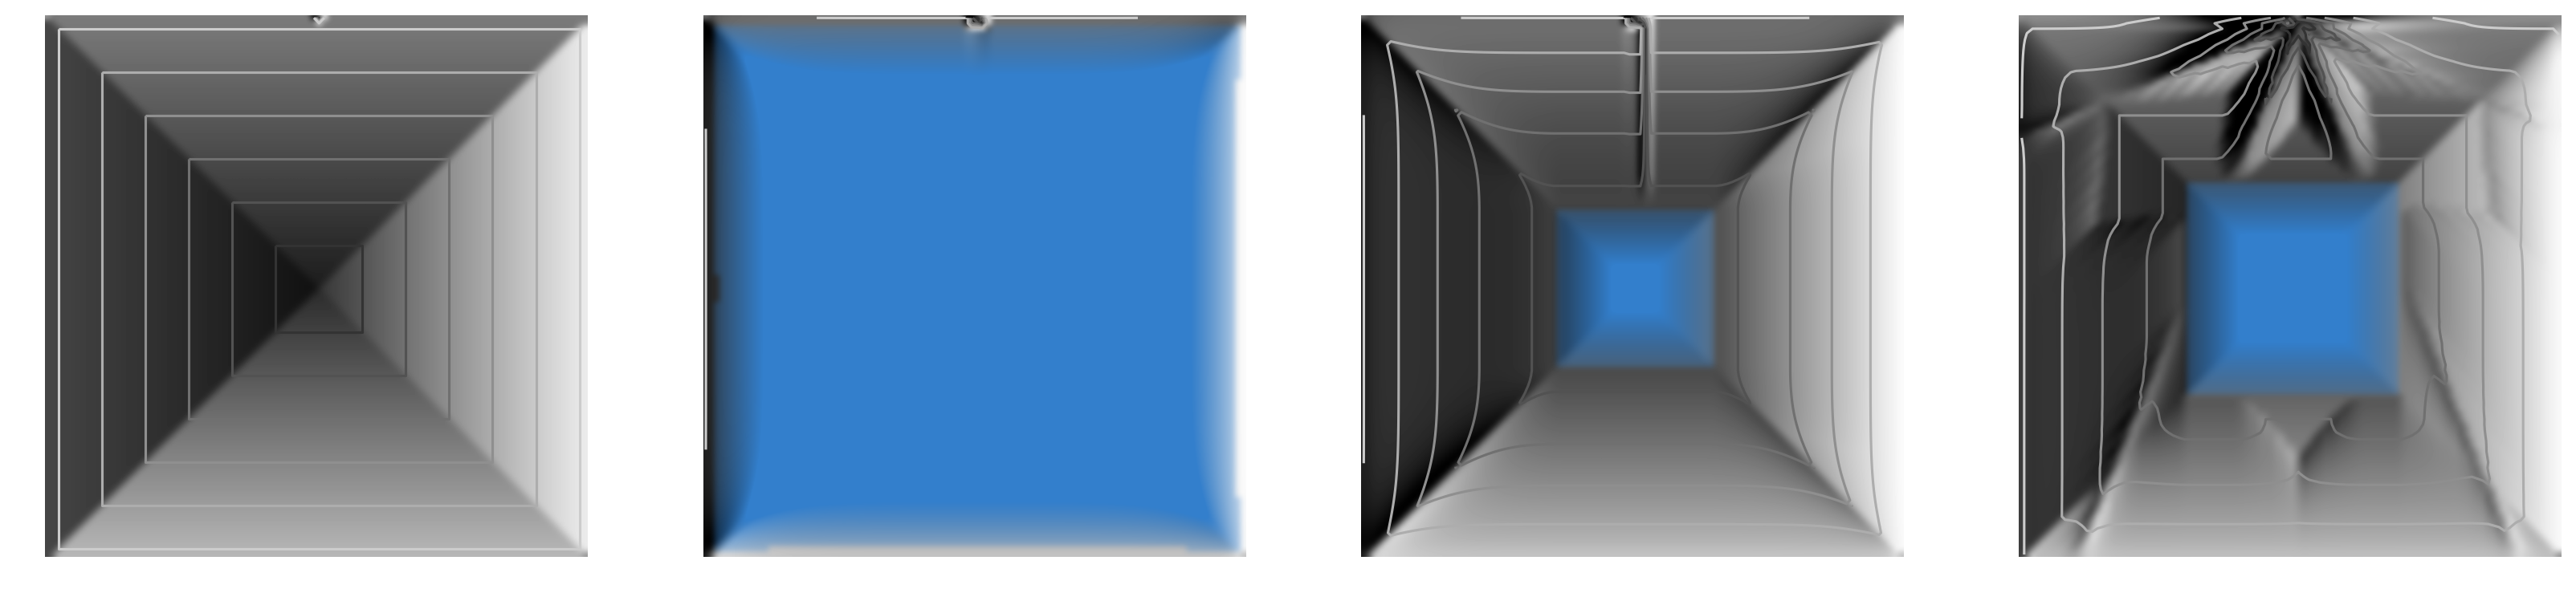

In [112]:
fig, axes = plt.subplots(ncols = 4, figsize=(22,5), dpi = 150)

def rescale(data, vmin = None, vmax = None, clip = False):
    if vmin is None:
        vmin = np.min(data)
    if vmax is None:
        vmax = np.max(data)
        
    if clip:
        return np.clip((data - vmin) / (vmax - vmin), 0, 1)
    else:
        return (data - vmin) / (vmax - vmin)
            
def illum(dem):

    intensity = rescale(hillshade(dem, scale=100.0, azdeg=290.0,altdeg=45.0), vmin = 0.695, vmax = .715, clip = True)
    alt = rescale(rescale(dem), vmin = -.3, vmax = 1)
    return  alt * intensity

def show(ax, data, water):
    axes[ax].imshow(illum(data), cmap =  plt.cm.gray, vmin = 0.0, vmax = 1.0, interpolation = 'bicubic')
    #axes[ax].imshow(data)

    ccmap = (lambda l, h : colors.LinearSegmentedColormap('gray_cm', {
        'red' : ((0,0,l), (1,h,0)),
        'green' : ((0,0,l), (1,h,0)),
        'blue' : ((0,0,l), (1,h,0)),
    })) (0.2, .8)
    
    out_data = data.copy()
    out_data[data != water] = np.nan

    axes[ax].contour(out_data, cmap = ccmap)
    
    
    lcmap = (lambda r, g, b : colors.LinearSegmentedColormap('alpha_cm', {
        'red' : ((0,r,r), (1,r,r)),
        'green' : ((0,g,g), (1,g,g)),
        'blue' : ((0,b,b), (1,b,b)),
        'alpha' : ((0,0,0), (1,1,1))
    })) (0.2, .5, .8)
    
    lake = water-data
    lake[lake != 0] += 5
    axes[ax].imshow(lake, cmap =  lcmap, vmin = 0.0, vmax = 15.0, interpolation = 'bicubic')
    
    axes[ax].axis('off')

    
show(0, elevation, elevation)
show(1, simple, wsimple)
show(2, carved, wcarved)
show(3, sloped, wsloped)




fig.tight_layout()
plt.savefig("jail.png")

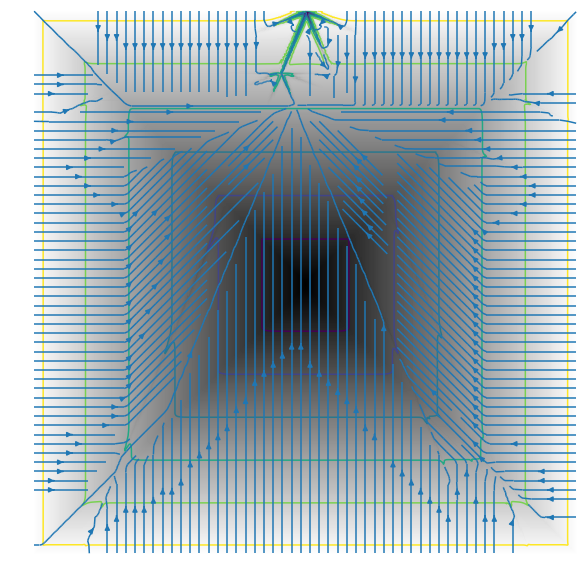

In [79]:
plt.figure(figsize=(10,10))
Y, X = np.mgrid[:angles.shape[0], :angles.shape[1]]
plt.imshow(sloped, cmap = plt.cm.gray)
plt.contour(sloped)
plt.streamplot(X, Y, np.cos(angles), np.sin(angles), density = 2);

In [67]:
import os
os.path.abspath('.')

'C:\\Users\\gcordonnier\\Documents\\code\\fastscapelib\\examples'

In [26]:
np.max(X)

499